# Phonon transport across Graphene Water Interface

### Objective 1

Obtaining the DOS for water-graphene system at the interface


### Geometry script
```tcl
package require nanotube
package require psfgen
package require solvate
package require topotools

graphene -lx 3 -ly 3 -type zigzag -b 0
set sel [atomselect top all]
$sel set segname GR1
$sel writepdb 1graphene.pdb
$sel writepsf 1graphene.psf

graphene -lx 3 -ly 3 -type zigzag -b 0
set sel [atomselect top all]
$sel set segname GR2
$sel moveby {0 0 40}
$sel writepdb 2graphene.pdb
$sel writepsf 2graphene.psf

readpsf  1graphene.psf
coordpdb 1graphene.pdb
readpsf  2graphene.psf
coordpdb 2graphene.pdb
writepsf gnc.psf
writepdb gnc.pdb

#solvate gnc.psf gnc.pdb -t 8.0 -o waterGnc
solvate gnc.psf gnc.pdb -minmax {{0 0 0} {30 30 40}} -b 0.5 -o waterGnc

mol load psf waterGnc.psf pdb waterGnc.pdb
set hyd [atomselect top "type HT"]
$hyd set type 1HT
$hyd set charge 0.4238
set oxy [atomselect top "type OT"]
$oxy set type 2OT
$oxy set charge -0.8476
set cnt [atomselect top "segname GR1 GR2"]
$cnt set type 3CA

topo writelammpsdata waterGnc.lmpsys

topo readlammpsdata waterGnc.lmpsys
set sel [atomselect top all]
set mm [measure minmax $sel]
set xlo [format %.4f [expr [lindex $mm 0 0]-0.71] ]
set xhi [format %.4f [expr [lindex $mm 1 0]+0.71] ]
set ylo [format %.4f [expr [lindex $mm 0 1]-0.61] ]
set yhi [format %.4f [expr [lindex $mm 1 1]+0.61] ]
set zlo [format %.4f [expr [lindex $mm 0 2]-2.0] ]
set zhi [format %.4f [expr [lindex $mm 1 2]+2.0] ]

exec sed -i "12s/.*/  $xlo $xhi  xlo xhi/" waterGnc.lmpsys
exec sed -i "13s/.*/  $ylo $yhi  ylo yhi/" waterGnc.lmpsys
exec sed -i "14s/.*/  $zlo $zhi  zlo zhi/" waterGnc.lmpsys

exec rm -f 1graphene.psf 2graphene.psf gnc.psf 
exec rm -f 1graphene.pdb 2graphene.pdb gnc.pdb 
exec rm -f waterGnc.log

mol delete all
exit
```

### Graphene Geometry



![Graphene-Water-System](https://rawgit.com/abhijithanandan/the-phonon-project/master/watGra.png)

### Specs

##### Graphene Sheets

No. of atoms | Type | n x m
:---: | :---: | :---:
416 | zigzag | 3 x 3

##### Water Box

No. of atoms | Type | No. mol.
:---: | :---: | :---:
3258| TIP3P| 1086

### Lammps Code
```lammps
echo		screen
units		real
atom_style	full
boundary	p p f 

#-------------------------------------------------------
#Reading data file
#-------------------------------------------------------

read_data	inputFiles/waterGnc.lmpsys

#-------------------------------------------------------
#Region and Group
#-------------------------------------------------------

region 		cold block INF INF INF INF 15 25
region 		Linterface block INF INF INF INF 0 2
region 		Linterface_dump block 10 20 10 20 0 2
region 		Rinterface block INF INF INF INF 38 40
region 		Rinterface_dump block 10 20 10 20 38 40

group 		water type 1 2 
group 		gnc   type 3 
group		Linterface region Linterface
group		Linterface_dump region Linterface_dump
group		Linterface_gra subtract Linterface water
group		Linterface_dump_gra subtract Linterface_dump water
group		Linterface_wat subtract Linterface gnc
group		Linterface_dump_wat subtract Linterface_dump gnc
group		Rinterface region Rinterface
group		Rinterface_dump region Rinterface_dump
group		Rinterface_gra subtract Rinterface water
group		Rinterface_dump_gra subtract Rinterface_dump water
group		Rinterface_wat subtract Rinterface gnc
group		Rinterface_dump_wat subtract Rinterface_dump gnc

#-------------------------------------------------------
#Potential
#-------------------------------------------------------
    
pair_style	hybrid lj/cut/coul/long 10.0 10.0 rebo  
kspace_style 	pppm 0.0001
kspace_modify	slab 3.0
bond_style   	harmonic
angle_style  	harmonic
pair_modify  	mix arithmetic shift yes

bond_coeff   	1 1000.0 1.0 
angle_coeff  	1 1000.0 109.47

pair_coeff   	* * lj/cut/coul/long 0.0 0.0		
pair_coeff      2 2 lj/cut/coul/long 0.15535 3.166	
pair_coeff   	2 3 lj/cut/coul/long 0.09369 3.19  	
pair_coeff	* * rebo inputFiles/CH.airebo_real NULL NULL C

#-------------------------------------------------------
#Neighbor 
#-------------------------------------------------------

neighbor	0.25 bin
neigh_modify    every 1 delay 0 check yes

#-------------------------------------------------------
#Initialization
#-------------------------------------------------------

velocity	all create 350 56986 mom yes rot yes dist gaussian

#-------------------------------------------------------
#Minimization
#-------------------------------------------------------

thermo          100  

fix		fxgnc gnc setforce 0.0 0.0 0.0
minimize 	1.0e-6 1.0e-6 100000 100000
unfix		fxgnc

#-------------------------------------------------------
#Equilibration run
#-------------------------------------------------------
thermo          100  
 
timestep	2.0

fix 		fxshk water shake 0.0001 20 0 b 1 a 1
fix 		fxnvt all nvt temp 350.0 350.0 100.0

run 		1000000

unfix fxnvt

#-------------------------------------------------------
#Attaching Heat Baths
#-------------------------------------------------------

compute		Thot Linterface_gra temp
compute		Tcold Rinterface_gra temp

fix 		fxnve all nve 
fix 		fxhot Linterface_gra langevin 400 400 100 56986 tally yes
fix		fxcold Rinterface_gra langevin 300 300 100 56489 tally yes

fix_modify	fxhot temp Thot
fix_modify	fxcold temp Tcold

#-------------------------------------------------------
#Temperature Calculation
#-------------------------------------------------------

compute		ke all ke/atom
variable	temp atom (c_ke/1.5)*503.49

compute 	cgrad all chunk/atom bin/1d z lower 1 #units reduced
fix		fgrad all ave/chunk 100 1000 100000 cgrad v_temp file temp.profile

#-------------------------------------------------------
#Velocity file 
#-------------------------------------------------------

dump		dmpvel_L_gra Linterface_dump custom 6 outputFiles/velLgra.dat id vx vy vz
dump		dmpvel_R_gra Rinterface_dump custom 6 outputFiles/velRgra.dat id vx vy vz
dump		dmpvel_L_wat Linterface_dump_wat custom 6 outputFiles/velLwat.dat id vx vy vz
dump		dmpvel_R_wat Rinterface_dump_wat custom 6 outputFiles/velRwat.dat id vx vy vz

#-------------------------------------------------------
#Thermo log file 
#-------------------------------------------------------

thermo_style    custom step temp pe ke etotal f_fxhot f_fxcold
thermo          100  
log             outputFiles/thermo.log

#-------------------------------------------------------
#Dcd file
#-------------------------------------------------------

dump            dmpall  all dcd 100 outputFiles/waterGnc.dcd

#-------------------------------------------------------
#Production run
#-------------------------------------------------------

run		100000
```

<blockquote>
Now the temperature and energy values are extracted form log file of <b> lammps code #1 </b> and written to the file 'thermo.dat' using the following bash commands
</blockquote>

``` bash
awk  'NR>=13 && NR<=1014 {print $0}' thermo.log > thermo.dat 
```

<blockquote>
The temperature and energy are plotted over time as follows:
</blockquote>

## Temperature vs Time

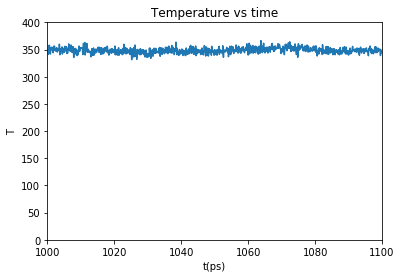

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
T = data[:,1]
t = data[:,0]
t = t/1000
#plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
plt.axis([1000,1100,0,400])
plt.ylabel("T")
plt.title("Temperature vs time")
plt.plot(t,T)
plt.show()

## Potential Energy vs time

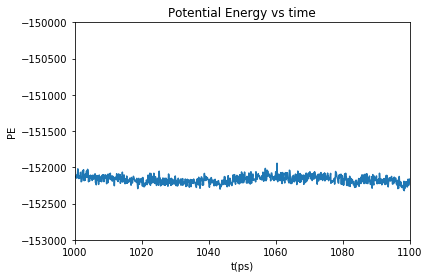

In [10]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
PE = data[:,2]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
#plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
plt.ylabel("PE")
plt.axis([1000,1100,-153000,-150000])
plt.title("Potential Energy vs time")
plt.plot(t,PE)
plt.show()

## Kinetic Energy vs time

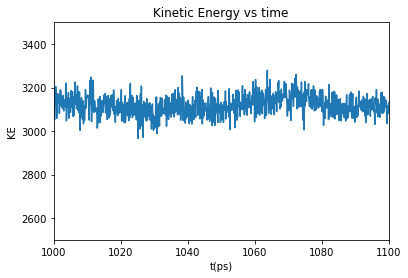

In [16]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
KE = data[:,3]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
#plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
plt.ylabel("KE")
plt.title("Kinetic Energy vs time")
plt.axis([1000,1100, 2500,3500])
plt.plot(t,KE)
plt.show()

## Total Energy vs Time

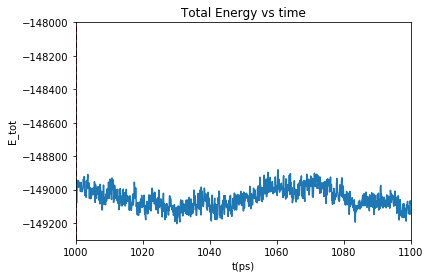

In [14]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("thermo.dat")
E = data[:,4]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
plt.axvline(x=1000, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.xlabel("t(ps)")
plt.ylabel("E_tot")
plt.axis([1000,1100,-149300,-148000])
plt.title("Total Energy vs time")
plt.plot(t,E)
plt.show()

## Post Processing


<blockquote>
The velocity data is obtained for group of graphene and water molecules seperately and are analysed with the following <b>bash<\b> script to seperate into different files for each atom.
</blockquote>



```bash
awk '/ITEM: ATOMS/,/ITEM: TIMESTEP/' velocity.dat > tmp.dat
sed -i '/ITEM/d' tmp.dat
mv tmp.dat vel.dat

sort -s -n -k1,1 vel.dat > velSorted.dat

awk 'NR%16667==0{print $1}' velSorted.dat > ids.dat

i=1
num=$(sed "${i}q;d" ids.dat)
while [ ${num} ]; 
do
	i=$(($i+1))
	awk '$1=='${num}'{print $0}' velSorted.dat > velxyz.tmp
	awk '{r=($2*$2+$3*$3+$4*$4)**0.5;}{printf"%d %0.20f %0.20f %0.20f %0.20f\n",$1,$2,$3,$4,r;}' velxyz.tmp > vel.tmp
	cp vel.tmp vel${num}.txt
	echo done $num 
	rm -f *.tmp	
	num=$(sed "${i}q;d" ids.dat)
done
```


<blockquote>

Once the velocity files are obtained from <b>lammps code #2</b> the following python script is used to calculate DOS from eqn:
</blockquote>


$$ DOS = fft \langle V \bigodot V \rangle $$

## Right Interface Graphene

0
1


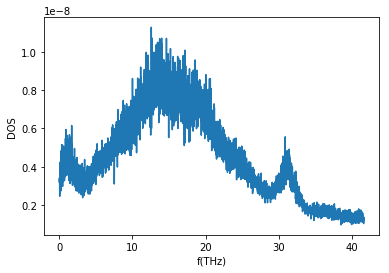

array([  6.49586831e-09,   6.80065844e-09,   6.30023996e-09, ...,
         6.85146606e-09,   6.30023996e-09,   6.80065844e-09])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scikits.talkbox.tools as tl
ids = np.loadtxt("ids_gra_R.dat")

tsteps = 16667
nvel = 6000
count = tsteps/nvel
n = 2**tl.nextpow2(nvel)
Dsum = 0
natoms = 50
Dt = 1
for j in range(count):
    Dx = 0
    Dy = 0
    Dz = 0
    for i in ids:
        val = int(i)
        fname = "velRgra"+str(val)+".txt"
        data = np.loadtxt(fname)
        Vx = data[nvel*(j):nvel*(j+1)-1,1]
        Vy = data[nvel*(j):nvel*(j+1)-1,2]
        Vz = data[nvel*(j):nvel*(j+1)-1,3]
        Dxsum = np.fft.fft(Vx,n)
        Dx = Dx + np.abs(Dxsum/n)**2
        Dysum = np.fft.fft(Vy,n)
        Dy = Dy + np.abs(Dysum/n)**2
        Dzsum = np.fft.fft(Vz,n)
        Dz = Dz + np.abs(Dzsum/n)**2
    print j   
    D = (Dx+Dy+Dz)/3/natoms
    Dsum = Dsum + D

DOS = Dsum/count
N = np.size(Dsum)
DOS_Gra_R = DOS[:N/2]
freq = np.fft.fftfreq(N,d = 0.012)
freq = freq
freq = freq[:N/2]
#freq = (1/(n*Dt*1e-15))*((0:np.size(DOS)-1)/1e15)
plt.xlabel("f(THz)")
plt.ylabel("DOS")
plt.plot(freq,DOS_Gra_R)
plt.show()
Dsum

## Right Interface Water 

0
1


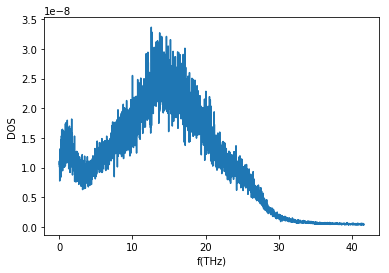

array([  2.11569024e-08,   2.21335710e-08,   2.01405922e-08, ...,
         2.23238050e-08,   2.01405922e-08,   2.21335710e-08])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scikits.talkbox.tools as tl
ids = np.loadtxt("ids_wat_R.dat")

tsteps = 16667
nvel = 6000
count = tsteps/nvel
n = 2**tl.nextpow2(nvel)
Dsum = 0
natoms = 15
Dt = 1
for j in range(count):
    Dx = 0
    Dy = 0
    Dz = 0
    for i in ids:
        val = int(i)
        fname = "velRwat"+str(val)+".txt"
        data = np.loadtxt(fname)
        Vx = data[nvel*(j):nvel*(j+1)-1,1]
        Vy = data[nvel*(j):nvel*(j+1)-1,2]
        Vz = data[nvel*(j):nvel*(j+1)-1,3]
        Dxsum = np.fft.fft(Vx,n)
        Dx = Dx + np.abs(Dxsum/n)**2
        Dysum = np.fft.fft(Vy,n)
        Dy = Dy + np.abs(Dysum/n)**2
        Dzsum = np.fft.fft(Vz,n)
        Dz = Dz + np.abs(Dzsum/n)**2
    print j   
    D = (Dx+Dy+Dz)/3/natoms
    Dsum = Dsum + D

DOS = Dsum/count
N = np.size(Dsum)
DOS_Wat_R = DOS[:N/2]
freq = np.fft.fftfreq(N,d = 0.012)
freq = freq
freq = freq[:N/2]
#freq = (1/(n*Dt*1e-15))*((0:np.size(DOS)-1)/1e15)
plt.xlabel("f(THz)")
plt.ylabel("DOS")
plt.plot(freq,DOS_Wat_R)
plt.show()
Dsum

### Combined DOS for Water and Graphene at Right Interface

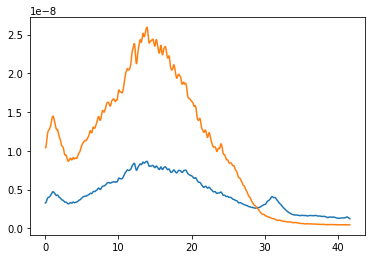

In [3]:
from pwtools import signal
import scipy

a = signal.smooth(DOS_Gra_R, scipy.signal.hann(50))
b = signal.smooth(DOS_Wat_R, scipy.signal.hann(50))
plt.plot(freq,a)
plt.plot(freq,b)
plt.show()

The results are also analysed with the welch funcion method described in "[The use of FFT for estimation of power spectra. A method based on time averaging over short modified Periodograms](https://www.utd.edu/~cpb021000/EE%204361/Great%20DSP%20Papers/Welchs%20Periodogram.pdf)"

For the purpose the following bash and python codes are used:

```bash

cd ../

mkdir dos dosx dosy dosz

cp ./outputFiles/velocity.dat ./dos/
cp ./analysis_scripts/split.sh ./dos/

cd ./dos/
./split.sh

cd ../

cp ./dos/ids.dat ./dosx/
cp ./dos/ids.dat ./dosy/
cp ./dos/ids.dat ./dosz/

cp ./analysis_scripts/dos.py ./dosx/
cp ./analysis_scripts/dos.py ./dosy/
cp ./analysis_scripts/dos.py ./dosz/

sed -i "6d" ./dosx/dos.py
sed -i "6i vel = vel[:,1]" ./dosx/dos.py

sed -i "6d" ./dosy/dos.py
sed -i "6i vel = vel[:,2]" ./dosy/dos.py

sed -i "6d" ./dosz/dos.py
sed -i "6i vel = vel[:,3]" ./dosz/dos.py

cp ./dos/vel*.txt ./dosx/
cp ./dos/vel*.txt ./dosy/
cp ./dos/vel*.txt ./dosz/

cp ./analysis_scripts/dos.sh ./dosx/
cp ./analysis_scripts/dos.sh ./dosy/
cp ./analysis_scripts/dos.sh ./dosz/

cp ./analysis_scripts/avg_dos.sh ./dosx/
cp ./analysis_scripts/avg_dos.sh ./dosy/
cp ./analysis_scripts/avg_dos.sh ./dosz/

cd ./dosx/
./dos.sh
./avg_dos.sh
cd ../

cd ./dosy/
./dos.sh
./avg_dos.sh
cd ../

cd ./dosz/
./dos.sh
./avg_dos.sh
cd ../

cp ./dosx/Pxx_avg.dat ./dos/dosx.dat
cp ./dosy/Pxx_avg.dat ./dos/dosy.dat
cp ./dosz/Pxx_avg.dat ./dos/dosz.dat

cp ./analysis_scripts/avg.sh ./dos/

cp ./dosx/freq.dat ./dos/

cd ./dos/
./avg.sh

mkdir analysis

mv dos ./analysis/
mv dosx ./analysis/
mv dosy ./analysis/
mv dosz ./analysis/
```
The python codes used in above script:

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

vel = np.loadtxt('vel.tmp')
vel = vel[:,1]
corr = np.correlate(vel,vel,mode='full')
N = np.size(corr)
corr = corr[:N/2]
f, Pxx_den = signal.welch(corr,fs=1.0,window='hamming',nperseg=5000,noverlap=2500,nfft=10000,detrend='constant', return_onesided=True)
np.savetxt("Pxx.tmp",Pxx_den)
np.savetxt("freq.dat",f)
```


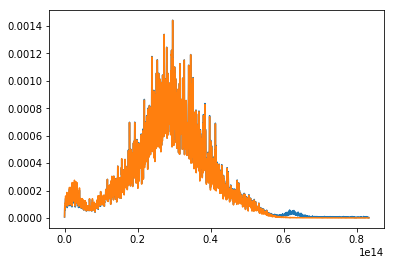

In [13]:
import numpy as np
import matplotlib.pyplot as plt

data_gra_R = np.loadtxt("dos_gra_R.dat")
data_wat_R = np.loadtxt("dos_wat_R.dat")
DOS_Gra_R = data_gra_R[:,1]
DOS_Wat_R = data_wat_R[:,1]
freq = data_gra_R[:,0]*(1/6e-15)
plt.plot(freq,DOS_Gra_R)
plt.plot(freq,DOS_Wat_R)
plt.show()

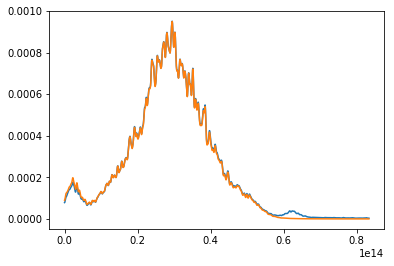

In [18]:
from pwtools import signal
import scipy

a = signal.smooth(DOS_Gra_R, scipy.signal.hann(50))
b = signal.smooth(DOS_Wat_R, scipy.signal.hann(50))
plt.plot(freq,a)
plt.plot(freq,b)
plt.show()